In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from edu.javerianacali.create_dataset import CreateDataSet
from edu.javerianacali.model.ccn_model import ConvulationalNeuralNetwork
from edu.javerianacali.model.logistic_regression_model import LogisticRegressionModel
from edu.javerianacali.process_images import ProcessImages
from edu.javerianacali.data_aumentation import DataAugmentation
from edu.javerianacali.model.svm_model import SupportVectorMachineModel
directorio = "/data/maestria/maestriasinpro/proyectodegrado/pujc-advocato-filter-project-mngr/assets"


# AUMENTO DE DATOS

In [ ]:

from edu.javerianacali.data_aumentation import DataAugmentation

DataAugmentation().augment_images(directorio+'/poquitas'

)

# PROCESAR INAGENES PARA MODELOS DE APRENDIZAJE SUPERVISADO

In [ ]:
path=directorio+'/poquitas'
archivos = os.listdir(path)
for archivo in archivos:
    if archivo.endswith((".jpg", ".JPG", ".jpeg", ".png")):
        ruta_imagen = os.path.join(path, archivo)
        titulos = ["Ori", "SinTex","Sinsomb", archivo]
        imagenes = ProcessImages().procesar_imagen(ruta_imagen,archivo,directorio,200,200)
        ProcessImages().mostrar_imagenes(titulos, imagenes)



# RED NEURONAL

In [ ]:
path=directorio
archivos = os.listdir(path)
for archivo in archivos:
    if archivo.endswith((".jpg", ".JPG", ".jpeg", ".png")):
        ruta_imagen = os.path.join(path, archivo)
        titulos = ["Ori", "SinTex","Sinsomb", archivo]
        imagenes = ProcessImages().procesar_imagen(ruta_imagen,archivo,directorio,200,200)
       # ProcessImages().mostrar_imagenes(titulos, imagenes)



In [2]:

CreateDataSet().create_dataset_cnn(directorio)

['fil_sano_tomada6.jpeg', 'fil_Heilipus (525).jpg', 'fil_aug_Sano_P14_140 degrees_0_3610.jpg', 'fil_sano (65).png', 'fil_aug_Sano_P15_50 degrees_0_6193.jpg', 'fil_aug_Sano_P18_40 degrees_0_438.jpg', 'fil_Elfresno164_003(1).png', 'fil_aug_Sano_P18_130 degrees_0_6129.jpg', 'fil_Heilipus (539).jpg', 'fil_sano(68).jpg', 'fil_Heilipus (105).jpg', 'fil_sano_tomada22.jpeg', 'fil_aug_Sano_P8_100 degrees_0_929.jpg', 'fil_Heilipus (84).jpg', 'fil_aug_Sano_P18_40 degrees_0_3686.jpg', 'fil_aug_Sano_P6_10 degrees_0_5505.jpg', 'fil_Heilipus (342).jpg', 'fil_aug_Sano_P12_20 degrees_0_8164.jpg', 'fil_Sano_P13_60 degrees.JPG', 'fil_Sano_P18_100 degrees.JPG', 'fil_aug_Sano_P5_60 degrees_0_9466.jpg', 'fil_aug_Sano_P14_140 degrees_0_3894.jpg', 'fil_Elfresno010_002.png', 'fil_Heilipus (277).jpg', 'fil_Heilipus (44).jpg', 'fil_aug_Sano_P19_50 degrees_0_1113.jpg', 'fil_Heilipus (361).jpg', 'fil_aug_Sano_P13_180 degrees_0_5495.jpg', 'fil_Heilipus (262).jpg', 'fil_aug_Sano_P16_60 degrees_0_8831.jpg', 'fil_Sano

In [3]:
from tensorflow.keras.utils import to_categorical
train_dir = directorio+'/train'  # Ajusta esta ruta
val_dir = directorio+'/test'  # Ajusta esta ruta

# Cargar datos
X_train, y_train, class_names_train = CreateDataSet().load_images_from_directory(train_dir)
X_val, y_val, class_names_val = CreateDataSet().load_images_from_directory(val_dir)

# Normalizar las imágenes
X_train = X_train / 255.0
X_val = X_val / 255.0

# Convertir las etiquetas a categóricas
y_train = to_categorical(y_train, num_classes=len(class_names_train))
y_val = to_categorical(y_val, num_classes=len(class_names_val))


In [4]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1))
class_weights = dict(enumerate(class_weights))


In [17]:
import tensorflow as tf
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

input_shape = (200, 200, 3)
input_tensor = Input(shape=input_shape)

modelo = Sequential([
   Conv2D(64, (3,3), activation='relu', padding="same", input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128, (3,3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(256, (3,3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(512, (3,3), activation='relu', padding="same"),  # Capa adicional
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(512, (3,3), activation='relu', padding="same"),  # Capa adicional
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dropout(0.5),  # Capa de abandono para regularización
    Dense(256, activation='relu'),  # Aumentar el número de nodos
    Dense(len(class_names_train), activation='softmax'),
 ])


modelo.summary()

learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)
modelo.compile(optimizer=optimizer , # Ajustar la tasa de aprendizaje
    loss='binary_crossentropy',  
    metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

historial = modelo.fit(
        X_train, y_train,
    epochs=50,  # Aumentar el número de épocas,
    batch_size=64,
      validation_data=(X_val, y_val),callbacks=[early_stopping, reduce_lr]

)



/home/maucasco/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,630,146 (32.92 MB)

 Trainable params: 8,630,146 (32.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - accuracy: 0.4854 - loss: 1062.7725 - val_accuracy: 0.4540 - val_loss: 0.6677 - learning_rate: 0.0100
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 71s 5s/step - accuracy: 0.6098 - loss: 1.0787 - val_accuracy: 0.5875 - val_loss: 0.6678 - learning_rate: 0.0100
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - accuracy: 0.5653 - loss: 0.7312 - val_accuracy: 0.6083 - val_loss: 0.6337 - learning_rate: 0.0100
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - accuracy: 0.7945 - loss: 0.5857 - val_accuracy: 0.9555 - val_loss: 0.1563 - learning_rate: 0.0100
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - accuracy: 0.8242 - loss: 0.5137 - val_accuracy: 0.8754 - val_loss: 0.4306 - learning_rate: 0.0100
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - accuracy: 0.7660 - loss: 0.4765 - val_accuracy: 0.9436 - val_loss: 0.1815 - learning_rate: 0.0100
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - accuracy: 0.9168 - loss: 0.2379 - val_accurac

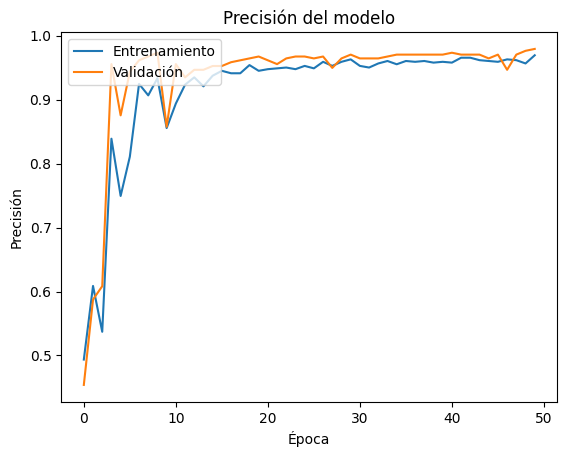

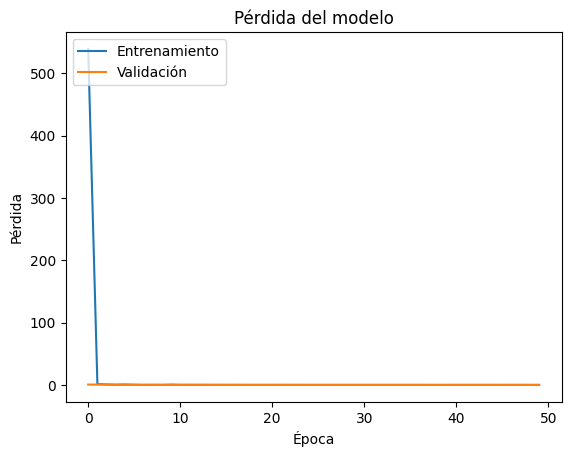

In [18]:

# Gráficos de precisión y pérdida
plt.plot(historial.history['accuracy'])
plt.plot(historial.history['val_accuracy'])  # Precisión de validación
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

plt.plot(historial.history['loss'])
plt.plot(historial.history['val_loss'])  # Pérdida de validación
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')# Añade la capa Dense según el tamaño de salida de Flatten


plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

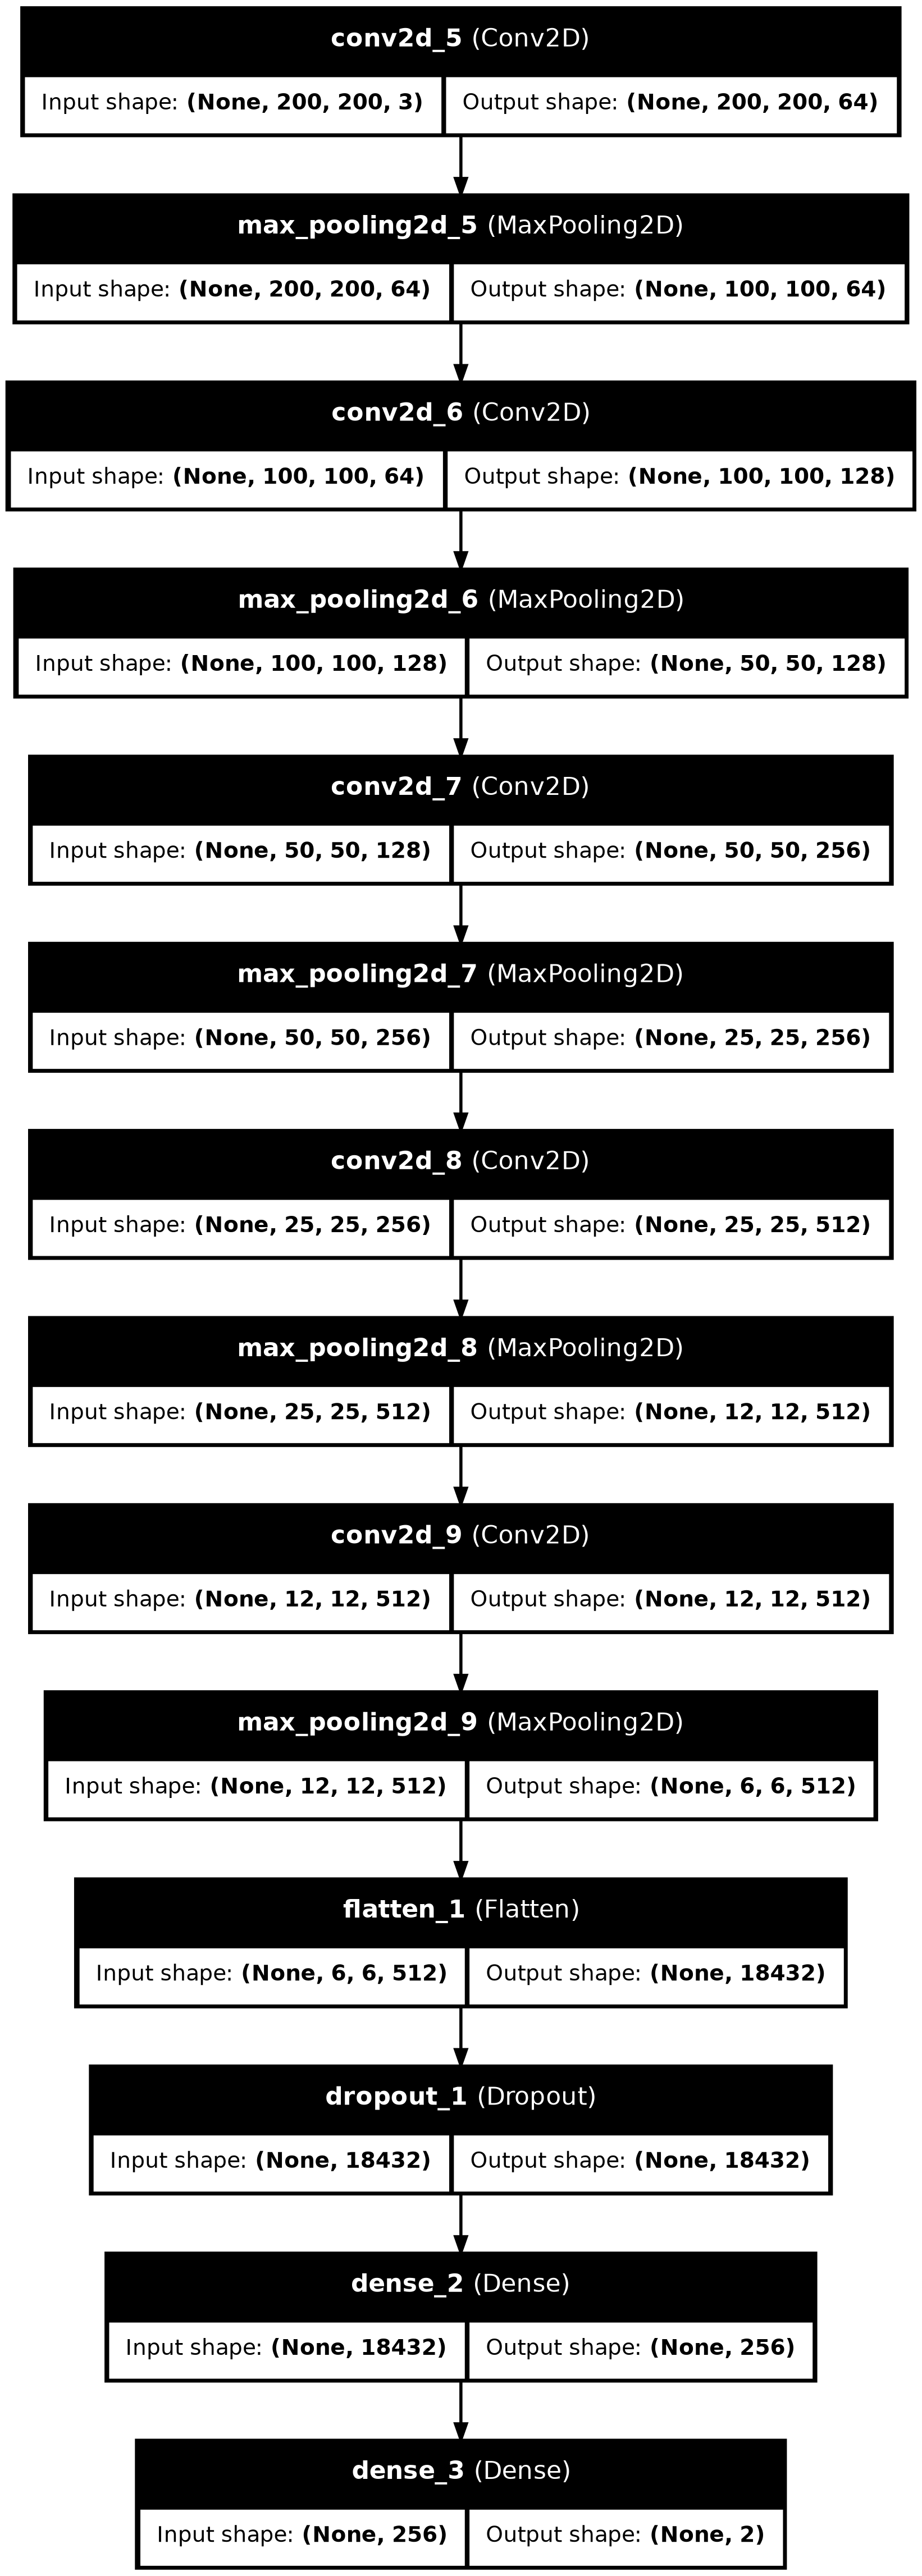

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(modelo, to_file='/data/maestria/maestriasinpro/proyectodegrado/pujc-advocato-filter-project-mngr/modelo1_cnn.png', show_shapes=True, show_layer_names=True)

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 766ms/step
Confusion Matrix


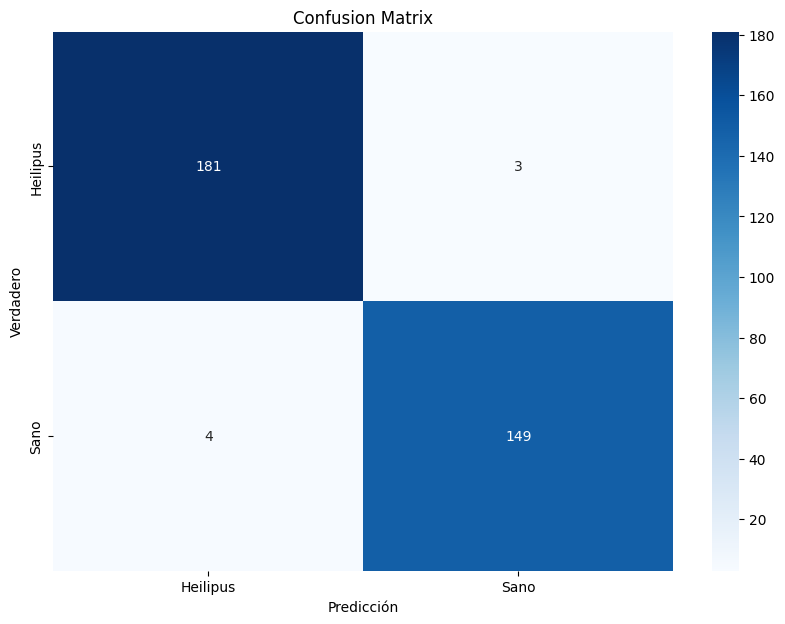

Classification Report
{'0': {'precision': 0.9783783783783784, 'recall': 0.9836956521739131, 'f1-score': 0.981029810298103, 'support': 184.0}, '1': {'precision': 0.9802631578947368, 'recall': 0.9738562091503268, 'f1-score': 0.9770491803278688, 'support': 153.0}, 'accuracy': 0.9792284866468842, 'macro avg': {'precision': 0.9793207681365577, 'recall': 0.97877593066212, 'f1-score': 0.979039495312986, 'support': 337.0}, 'weighted avg': {'precision': 0.9792340794644402, 'recall': 0.9792284866468842, 'f1-score': 0.9792225806677, 'support': 337.0}}


,precision,recall,f1-score,support
0,0.978378,0.983696,0.981030,184.000000
1,0.980263,0.973856,0.977049,153.000000
accuracy,0.979228,0.979228,0.979228,0.979228
macro avg,0.979321,0.978776,0.979039,337.000000
weighted avg,0.979234,0.979228,0.979223,337.000000


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
# Evaluar el modelo en el conjunto de prueba o validación
# Asumiendo que tienes `validation_generator` como tu conjunto de validación/test
# Realizar predicciones en el conjunto de validación
y_pred = modelo.predict(X_val)
y_test = np.argmax(y_val, axis=1)  # Etiquetas verdaderas
y_pred = np.argmax(y_pred, axis=1)  # Convertir predicciones a etiquetas


# Matriz de confusión
print("Confusion Matrix")
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)


# Visualización de la matriz de confusión
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names_val, yticklabels=class_names_val)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Confusion Matrix')
plt.show()


# Informe de clasificación

report = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report")
print(report)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv('classification_report_cnn.csv', index=True)

cm = sns.light_palette("blue", as_cmap=True)
styled_df = report_df.style.background_gradient(cmap=cm)
display(styled_df)


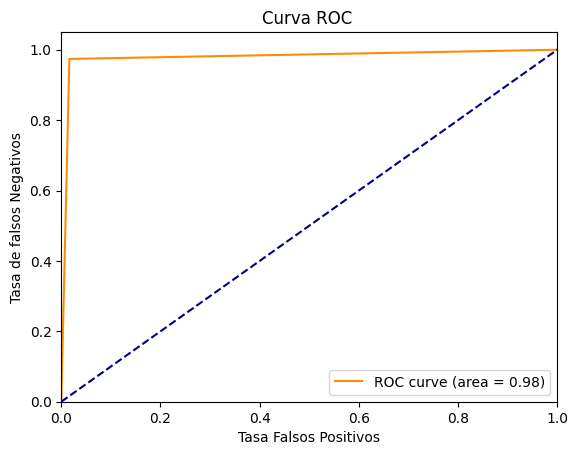

In [21]:
# Si y_pred es unidimensional, no necesitas indexarlo con [:, 1]
if y_pred.ndim == 1:
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Visualización de la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa Falsos Positivos')
    plt.ylabel('Tasa de falsos Negativos')
    plt.title('Curva ROC ')
    plt.legend(loc="lower right")
    plt.show()

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model

# Verificar que el modelo está correctamente definido
print("Resumen del modelo:")
modelo.summary()

# Imprimir las capas del modelo para verificar el índice correcto
print("Capas del modelo:")
for i, layer in enumerate(modelo.layers):
    print(f"Índice: {i}, Nombre de la capa: {layer.name}, Tipo de capa: {type(layer)}")

# Suponiendo que ya tienes tu modelo entrenado y los datos cargados
# X_val y y_val son tus datos de validación y etiquetas

# Selecciona una imagen del conjunto de validación para visualizar las activaciones
image_to_visualize = X_val[2]

# Verifica las dimensiones de la imagen
print("Dimensiones de la imagen:", image_to_visualize.shape)

# Asegúrate de que la imagen tiene las dimensiones correctas (200, 200, 3)
if image_to_visualize.shape != (200, 200, 3):
    image_to_visualize = cv2.resize(image_to_visualize, (200, 200))

# Normaliza la imagen
image_to_visualize = image_to_visualize / 255.0

# Crear un modelo que devuelva las activaciones de la primera capa convolucional
# Cambia "0" a la capa que deseas visualizar si no es la primera capa
layer_index = 0
# Realiza una llamada al modelo para establecer sus dimensiones de entrada
_ = modelo.predict(image_to_visualize.reshape(1, 200, 200, 3))



activation_model = Model(inputs=modelo.input, outputs=modelo.layers[0].output)
activations = activation_model.predict(image_to_visualize.reshape(1, 200, 200, 3))

# Verifica las dimensiones de las activaciones
print("Dimensiones de las activaciones:", activations.shape)

# Visualizar las activaciones de los primeros 6 filtros
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    if i < activations.shape[-1]:  # Asegúrate de que el índice está dentro del rango de filtros disponibles
        ax.imshow(activations[0, :, :, i], cmap='viridis')
    ax.axis('off')
plt.show()
   
# Obtener las activaciones de la primera capa convolucional para la imagen seleccionada



Resumen del modelo:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,890,440 (98.76 MB)

 Trainable params: 8,630,146 (32.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,260,294 (65.84 MB)

Capas del modelo:
Índice: 0, Nombre de la capa: conv2d_5, Tipo de capa: <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
Índice: 1, Nombre de la capa: max_pooling2d_5, Tipo de capa: <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
Índice: 2, Nombre de la capa: conv2d_6, Tipo de capa: <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
Índice: 3, Nombre de la capa: max_pooling2d_6, Tipo de capa: <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
Índice: 4, Nombre de la capa: conv2d_7, Tipo de capa: <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
Índice: 5, Nombre de la capa: max_pooling2d_7, Tipo de capa: <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
Índice: 6, Nombre de la capa: conv2d_8, Tipo de capa: <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
Índice: 7, Nombre de la capa: max_pooling2d_8, Tipo de capa: <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
Índice: 8, Nombre de la capa: conv2d_9, Tipo de capa: 

ValueError: The layer sequential_1 has never been called and thus has no defined input.

In [20]:
# Guardar el modelo en un archivo
modelo.save('/data/maestria/maestriasinpro/proyectodegrado/pujc-advocato-filter-project-mngr/modelo_cnn.h5')


In [ ]:
# Cargar el modelo desde un archivo
from keras.models import load_model
modelo = load_model('/home/maucasco/Documents/maestria/proyecto_grado/pujc-advocato-filter-project-mngr/modelo/modelo_cnn.h5')

In [ ]:

from keras.preprocessing import image
import numpy as np
# Load and preprocess the image
img_path = '/home/maucasco/Downloads/images.jpeg'
imagen = cv2.imread(img_path)[100:, :]
imagen_sin_texto,aguacate_solo, redimenciada = ProcessImages().procesar(imagen,500,500)
img_array = image.img_to_array(redimenciada)


plt.imshow(redimenciada, cmap='gray')
plt.show()
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Make predictions
predictions = modelo.predict(img_array)
print(predictions)